# 예상 질문 모음

### 1. 매번 Spotify API를 호출하면 무리가 있지 않나?
##### 당연히 무리가 있습니다.
**Solution** : API를 최대한 호출하지 않게 하기 위해서 audio-features, 가수별 장르정보와 같은 경우에는 Spotify에서 매번 가지고오지 않고SeedZone Database에 사용자가 추천음악 프로세스에 사용한 음악들의 정보를 쌓아놓듯이, 추천 프로세스에 사용된 음악의 audio-features, 가수별 장르정보는 MuLetter 내부 Database에 저장시킬 예정입니다.

### 2. SeedZone Observer는 관리자가 실행시키는 것 인가?
##### 아닙니다.
SeedZone Observer에 Observer를 붙여서 네이밍 한 것에는 이유가 있습니다. 사용자들이 우체통을 등록하거나 편지에 답장을 해주면 SeedZone Database에 추천 프로세스에 쓰일 음악을 넣는 과정에서 SeedZone Observer가 SeedZone Database에 있는 Seed 음악수를 체크합니다.<br/>
그리고 앞서 발표했던 KMeans Based Recommender에서 Rule of Thumb 수식으로 K개수를 선정했는데, 음악이 계속 추가되어 Rule of Thumb 수식에 의해 기존 SeedZone Clustering 정보보다 많은 수의 K를 만들어낼 수 있으면 SeedZone Clustering이 동작합니다.<br/>
추가적으로 음악이 계속 추가될 때 새로 추가된 음악에게 현재 SeedZone Clustering 정보를 토대로 라벨을 부여해주는데, 이 과정에서 ECV도 계속해서 업데이트 시킵니다. SeedZone Observer는 ECV 수치가 많이 낮아졌을 때, 그 때에도 SeedZone Clustering을 동작 시킵니다.<br/>
<br/>
추가적으로 SeedZone 클러스터링 작업이 진행될 때마다 프로세스가 종료되면 모든 Coord Generator에게 새로운 클러스터링 정보의 생성을 알리고 Coord Generator는 모든 우체통들의 좌표를 새 Clustering 정보에 맞춰서 재 부여 합니다.

### 3. 많은 클러스터링 알고리즘 중에 왜 KMeans Clustering을 채택했나? or ECV 관련 질문
장점에서도 언급했듯이 사이킷런의 의존도를 없앨 수 있다는 점에서 채택했습니다. 그리고 장점의 연장선으로 말씀드렸던게 ECV라는 품질평가를 사용했다라는 점 인데요. 저희 추천 시스템에서 클러스터링 알고리즘은 필터링의 역할만 수행하기 때문에 평가 수치 자체가 그렇게 중요하지 않아요.<br/>
근데 ECV는 사이킷런에서 제공하지 않는 품질평가 방식입니다. 직접 구현했기 때문에 라이브러리에서 지원하지 않는 방식을 도입할 수 있었고,<br/> 저희는 남길 수 있는 프로젝트를 진행하자가 공동의 목표인데, KMeans Process를 이해하고 직접구현할 수 있다는, 넓은 의미로 풀어내면 알고리즘의 대한 저희들의 이해도를 남기면 좋을 거 같아서 클러스터링 알고리즘 중에 가장 쉬운 KMeans Clustering을 채택했습니다.

### 4. Coord Generator가 클러스터 성향을 좌표계로 변환시키는 과정을 자세하게 설명?
##### Detail 하게 프로그램 구현하기

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

from demo.lib import DB
from demo import SeedZoneObserver, CoordGenerator

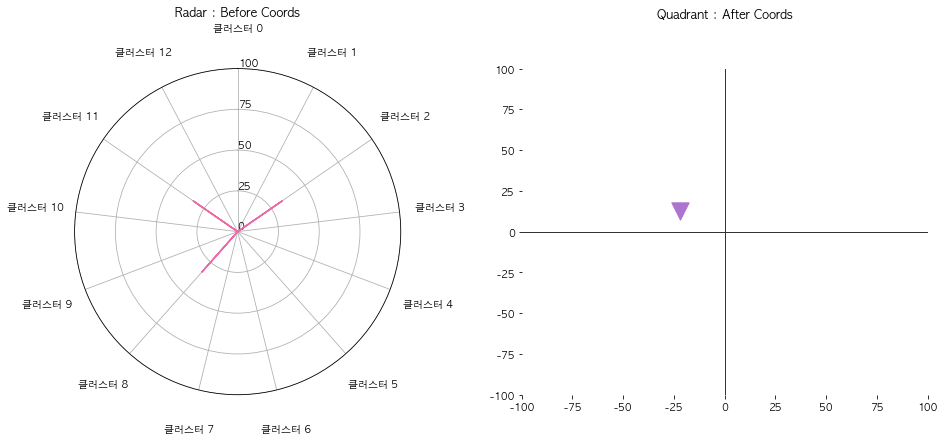

In [78]:
ran_mailbox = DB().random_mailbox()
gen = CoordGenerator(str(ran_mailbox['_id']))

gen.make_coords()
gen.draw_coord()

#### 이것이 어떻게 만들어지는 것 이냐면요

In [79]:
import pandas as pd

tracks = pd.DataFrame(gen.mailbox['tracks'])
tracks.head()

,trackId,trackName,artistIds,artistNames,image
0,5BhK8Mho223YLPQOLfzWNP,Killing Me,5FxD8fkQZ6KcsSYupDVoSO,Omar Apollo,https://i.scdn.co/image/ab67616d0000b2734a9842...
1,0GsRx0gPft6RmijIwMsKmG,Friday (feat.Jang Yi-jeong),3HqSLMAZ3g3d5poNaI7GOU,IU,https://i.scdn.co/image/ab67616d0000b27315b8ce...
2,3XYRV7ZSHqIRDG87DKTtry,Permission to Dance,3Nrfpe0tUJi4K4DXYWgMUX,BTS,https://i.scdn.co/image/ab67616d0000b2739c1946...


사용자에 우체통에는 이런 노래들이 등록되어 있어요. 그리고 이들은 모두 추천 프로세스에 한 번씩 사용이 됐었기 때문에 SeedZone Database에 들어있을테구요. 이 친구들이 SeedZone Observer의 클러스터링 대상이 됩니다.

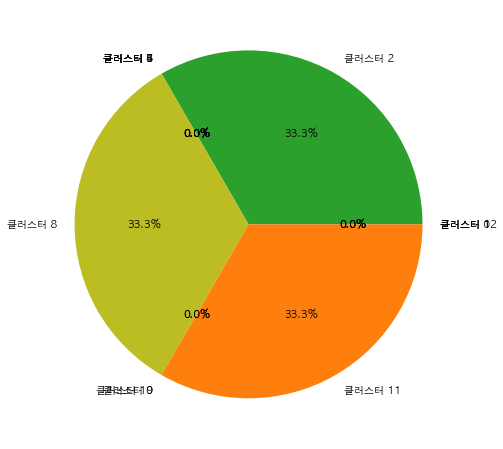

In [80]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

lp = np.array(gen.mailbox['_labelPercentages'])
plt.figure(figsize=(8,8))

plt.pie(lp, autopct='%.1f%%',labels=["클러스터 {}".format(_) for _ in range(len(lp))])

plt.show()

그러면 사용자가 가지고 있는 총 음악 개수에 각 라벨 숫자들을 그룹화하여 각 각의 클러스터 성향으 수를 나눠주면 사용자가 어느 성향의 음악들을 가지고 있는지 비율적으로 알 수 있겠죠?

성향 0의 개수: 10
좌표 생성에 쓰일 값 개수: 3
[[-21.88304772  12.79141859]
 [-21.88304772 -24.70085469]
 [-27.15846757  18.74613664]]


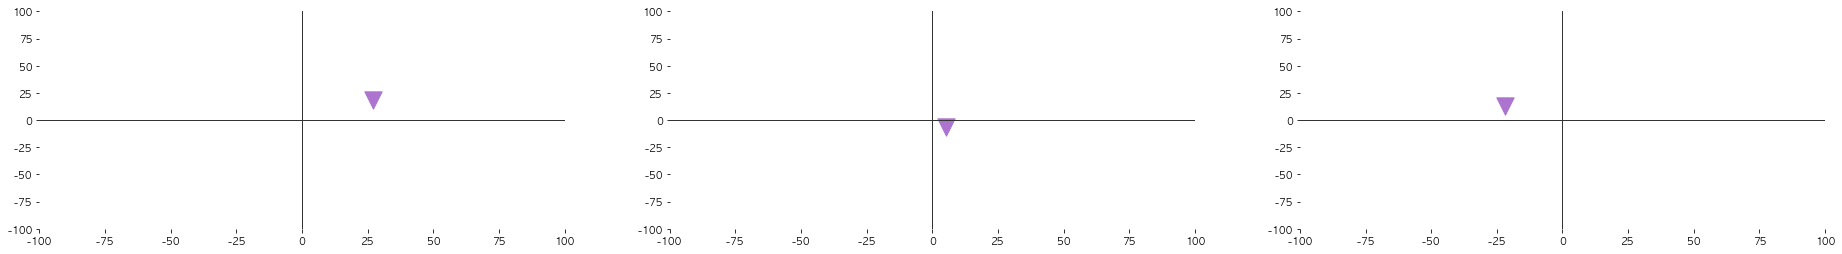

In [81]:
from demo.CoordGenerator import get_coord
import numpy as np

print("성향 0의 개수:", lp[lp == 0].size)
print("좌표 생성에 쓰일 값 개수:", lp[lp != 0].size)

detail, point = get_coord(lp, detail=True)

plt.figure(figsize=(32,4))

for idx,_detail in enumerate(detail):
    ax = plt.subplot(1,len(detail), idx + 1)
    
    if idx == 0:
        point_movement = _detail
    else:
        point_movement += _detail
        
    ax.axvline(0, color="#333", linewidth=1)
    ax.axhline(0, color="#333", linewidth=1)

    plt.scatter(point_movement[0], point_movement[1], color='#AC73CF', s=300, marker='v')

    plt.ylim(-100, 100)
    plt.xlim(-100, 100)
    
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

print(detail)
plt.show()

여기서 클러스터 성향을 각도로, 그리고 비율을 거리로 사용하여 이를 사분면에 나타낸다면 각 클러스터 성향의 각도쪽으로 직선거리상으로는 어떻게 가야할까에 대한 변환을 해줍니다.<br/>
그리고 이들을 모두 합해주면 됩니다. 

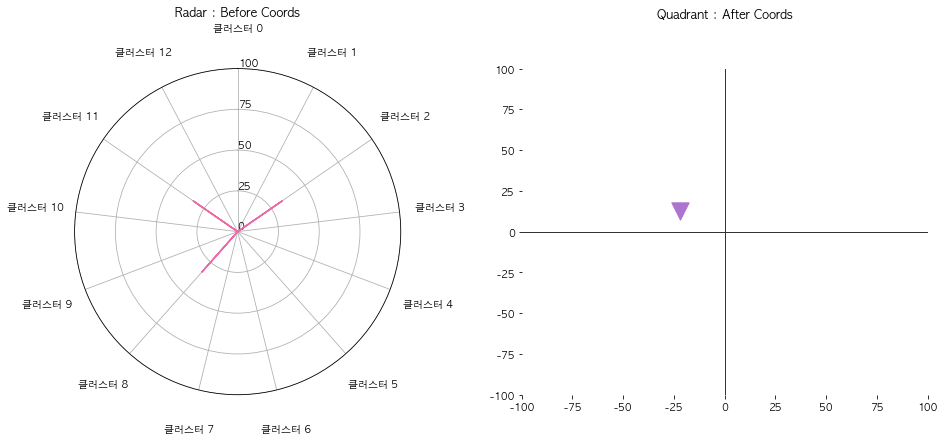

In [82]:
gen.draw_coord()

### 5. 해당 추천 프로그램을 어떻게 탑재할건가? <br/> 추천 프로세스가 오래걸릴텐데 사용자한테는 어떻게 제공해줄 것 인가?
백엔드 서버와 머신러닝 서버는 node js로 구현이 될것입니다. 그렇다고 해당 프로그램을 javascript로 바꾸지는 않을 거구요. 자바스크립트에 child-process라는 라이브러리가 있는 데 그것을 통해 파이썬 프로그램을 실행시킬 거에요. 연동의 개념이 아니고, 아예 프로그램을 실행시키는 개념으로 접근하는 거죠.
그리고 파이썬 프로그램에서 추천 프로세스가 종료되면 백엔드 서버에 종료 API를 호출할 겁니다. 이 때 어떤 우체통에 대한 편지 작성이 끝났는지와 같은 정보가 Body에 담기겠죠?<br/>

여기서 오래걸리는 면에 있어서는 소켓을 사용할 겁니다. 백엔드 서버에 종료 API가 호출될 때 해당 우체통이 어떤 사용자의 우체통인지를 확인하고 해당 사용자의 소켓 아이디를 조회하여 프론트엔드에 알림이 뜨도록 할 거에요.

### 6. 추천 음악은 한번만 제공이 되는가?
발표 시간 상 내용에는 넣지 않았는데요. 편지 UI에 좋아요 표시가 붙게될거에요. 사용자는 자신이 받은 추천음악 플레이리스트에서 마음에 들었던 음악들에 좋아요를 눌러서 MuLetter 시스템에게 답장을 해주면 MuLetter 시스템은 사용자가 좋아요를 누른 음악을 토대로 추천음악프로세스를 다시 진행하고, 사용자에게 새 편지를 작성해줍니다.

### 7. 추천 음악은 재생할 수 있나요?
네 재생할 수 있는 스트리밍 기능을 넣을겁니다.<br/>
하지만 안타깝게도 스포티파이에서 제공해주는 스트리밍 API를 이용할 것 이기 때문에 스포티파이 요금제에 가입된 사용자들만 사용할 수 있어요. 이것은 사용자의 스포티파이 계정과의 연동을 통해 구현할 것 이구요.<br/>
그렇지 않은 사용자들에게는 아쉬운대로 유튜브 검색 링크라도 제공할 예정입니다.

### 8. 어떤 것을 토대로 저 추천음악들이 사용자를 위한 추천음악들이라고 말할 수 있나요?
일단 스포티파이라는 회사의 이야기부터 해드릴게요. 스포티파이는 음악 스트리밍 플랫폼들 중에서 추천서비스에 특화되어 있는 플랫폼 입니다. 우리 나라의 대표적인 플랫폼 중 하나인 FLO에서도 Spotify의 추천시스템을 칭찬하는 글을 작성했을 정도에요.<br/>
그 글을 보게되면 스포티파이라는 회사가 추천 서비스에 엄청난 투자를 진행하고 있다는 것을 확인할 수 있어요. 데이터 가공에 힘을 쓰고, 매년 데이터 관련된 많은 논문들을 발표하고, 데이터를 잘 다루는 회사를 인수하는 등 같은 것들을 스포티파이에서 진행하고 있습니다.<br/>
이런 배경들이 깔려서 스포티파이에서 제공해주는 하이레벨 오디오 분석 데이터에 신뢰성을 보장한 상태로 진행한 것이 MuLetter 입니다. 추천을 잘 하기로 유명한 Spotify가 추천해준 음악들을 저희는 서드파티의 역할로 알짜배기만 골라 필터링을 해서 사용자에게 제공을 해드리는 것 이니까요. 오디오 분석 데이터 상으로는 사용자를 위한 추천음악들이라고 말할 수 있습니다.<br/>
또한 사용자가 우체통을 어떻게 구성하느냐에 따라 추천 음악들의 구성도 바뀔 테니까요. MuLetter에서는 사용자가 자신의 취향을 얼마나 잘 반영되게 우체통을 만들었느냐도 자신이 찾고 싶은 음악들을 얻어내는 방법입니다.

### 9. 클러스터링 라벨들은 뒤죽박죽인데 어떻게 Coord Generator가 동작할 수 있는가?
SeedZone Observer가 하는 클러스터링 작업에는 정렬작업이 붙습니다.<br/>
이 정렬 메커니즘은 클러스터 중심값들 중에 가장 전체 중심값들과 유사한 클러스터를 0도에 배치하고 양쪽 각도에 해당 클러스터와 유사한 클러스터, 그리고 다음 라운드에서는 이전 각도로 도출된 클러스터들과 유사한 클러스터, 이러한 방식으로 원을 그려갑니다. <br/>
작업이 끝나면 결과적으로 0도에 배치되었던 클러스터 중심값과 반대쪽에 배치되어 있는 클러스터 중심값들은 많이 다른 형태를 띄게 되는 거죠.

### 10. KMeans++ 초기 중심값 선정 방식